In [10]:
import pandas as pd
df = pd.read_csv('newnew.csv',index_col=0)
df = df.sort_values(['交易年', '交易月','交易日'], ascending=[True, True,True])

In [11]:
# log fix 
import numpy as np
not_fix = ['forex','twse_stock_market','車位總價元','單價元平方公尺','總價元','移轉層次','交易年','交易月','交易日','屋齡byDay']
col = [l for l in list(df.columns) if l not in not_fix]
for i in col:
    df[i]=(np.log1p(df[i].dropna()))

# shift and log
df['移轉層次'] = np.log1p(df['移轉層次'] + abs(df['移轉層次'].min()))
df['屋齡byDay'] = np.log1p(df['屋齡byDay'] + abs(df['屋齡byDay'].min()))

沒有缺失值


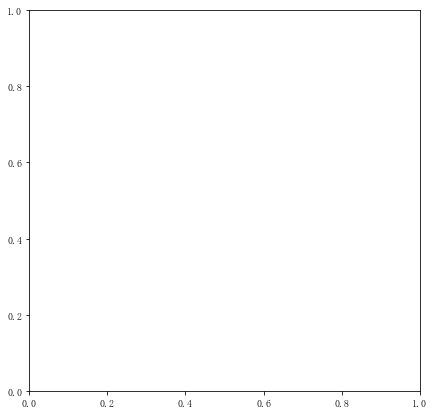

In [12]:
# check nan
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from package.tools import missing_plot
%matplotlib inline
missing_plot(df) 

In [13]:
from sklearn.model_selection import train_test_split
import gc
# from sklearn.preprocessing import StandardScaler
df = df.dropna() #
print(len(df))
x = df.drop(columns=['總價元','單價元平方公尺'])
col = x.columns
x = np.array(x)
y = np.array(df['單價元平方公尺'])
gc.collect()

# 70% train 30% test data
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size = .3, random_state=46)

# https://daniel820710.medium.com/%E5%88%A9%E7%94%A8keras%E5%BB%BA%E6%A7%8Blstm%E6%A8%A1%E5%9E%8B-%E4%BB%A5stock-prediction-%E7%82%BA%E4%BE%8B-1-67456e0a0b
# https://stackoverflow.com/questions/54416322/expected-ndim-3-found-ndim-2
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
from tensorflow.python import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Activation
x_train = x_train.reshape(-1, 1, 233)
x_test  = x_test.reshape(-1, 1, 233)
y_train = y_train.reshape(-1, 1, 1)
y_test = y_test.reshape(-1, 1, 1)
gc.collect()

51987


0

In [14]:
# from tensorflow.keras.engine.topology import Layer
# https://blog.csdn.net/yunfeather/article/details/106461754
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as K

from tensorflow import keras
model = keras.models.Sequential()

model.add(keras.layers.LSTM(128, input_shape=(1, 233), return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(64, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.LSTM(64, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(64, return_sequences=True))
# model.add(keras.layers.Dense(32, activation="relu"))

model.add(keras.layers.Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics= ['mean_squared_error'])

get_best_model = keras.callbacks.ModelCheckpoint(
    filepath='house_data/lstm.mdl',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
# https://wenwu53.com/keras2-0/
history = model.fit(
    x_train,  
    y_train, 
    batch_size=2000, 
    epochs=30,
    validation_split=0.2, #validation_data=(x_test,y_test) ## 為避免訓練未來資料，用驗證資料集自己切
    callbacks=[get_best_model])

Epoch 1/30
15/15 [==============================] - 4s 285ms/step - loss: 145.3783 - mean_squared_error: 145.3783 - val_loss: 140.8890 - val_mean_squared_error: 140.8890
Epoch 2/30
15/15 [==============================] - 1s 76ms/step - loss: 128.2007 - mean_squared_error: 128.2007 - val_loss: 99.8758 - val_mean_squared_error: 99.8758
Epoch 3/30
15/15 [==============================] - 1s 76ms/step - loss: 65.3860 - mean_squared_error: 65.3860 - val_loss: 26.9292 - val_mean_squared_error: 26.9292
Epoch 4/30
15/15 [==============================] - 1s 80ms/step - loss: 14.5733 - mean_squared_error: 14.5733 - val_loss: 4.6673 - val_mean_squared_error: 4.6673
Epoch 5/30
15/15 [==============================] - 1s 79ms/step - loss: 2.7187 - mean_squared_error: 2.7187 - val_loss: 0.9069 - val_mean_squared_error: 0.9069
Epoch 6/30
15/15 [==============================] - 1s 80ms/step - loss: 0.6414 - mean_squared_error: 0.6414 - val_loss: 0.2499 - val_mean_squared_error: 0.2499
Epoch 7/30
15

In [55]:
## easy test LSTM
# model = Sequential()
# model.add(LSTM(100, input_shape=(1, 233), return_sequences=True))
# model.add(LSTM(1, input_shape=(1, 233), return_sequences=True))
# model.compile(loss="mean_squared_error", optimizer="adam", metrics= ['mean_squared_error'])

# # can run but got nan output
# history = model.fit(x_train,y_train,epochs=3, validation_data=(x_test,y_test))

In [69]:
y_train.shape

(25822, 1, 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 128)            185344    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 64)            

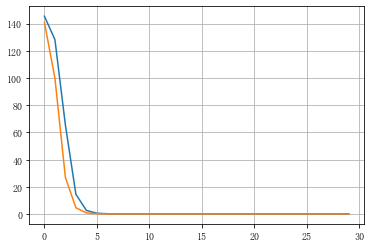

In [15]:
model.load_weights("house_data/lstm.mdl")
print(model.summary())
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15,10
%matplotlib inline
plt.plot(history.history['loss']) # blue
plt.plot(history.history['val_loss']) # yellow
plt.grid()

In [16]:
import math
import sklearn.metrics as sklm

p_tr = model.predict(x_train)
p_test = model.predict(x_test)

tr_score = math.sqrt(sklm.mean_squared_error(y_train[:,0], p_tr[:,0]))
print('Train Score: %f RMSE' % (tr_score))
testScore = math.sqrt(sklm.mean_squared_error(y_test[:,0], p_test[:,0]))
print('Test Score: %f RMSE' % (testScore))

Train Score: 0.418265 RMSE
Test Score: 0.423383 RMSE


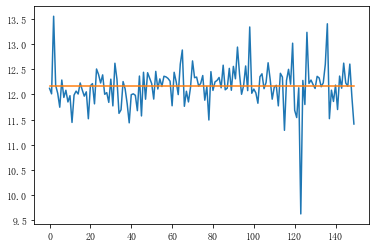

In [17]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15,10
%matplotlib inline
# plt.plot(y_train[:50,0])
# plt.plot(p_tr[:50,0])
plt.plot(y_test[:150,0])
plt.plot(p_test[:150,0])

In [9]:
# https://stackoverflow.com/questions/42861460/how-to-interpret-weights-in-a-lstm-layer-in-keras
# https://stackoverflow.com/questions/46953279/understand-keras-lstm-weights
for e in zip(model.layers[0].trainable_weights, model.layers[0].get_weights()):
    print('Param %s:\n%s' % (e[0],e[1]))

Param <tf.Variable 'lstm/lstm_cell/kernel:0' shape=(233, 512) dtype=float32, numpy=
array([[-0.03642824, -0.05468637,  0.08618248, ..., -0.05480751,
        -0.08330426,  0.08039205],
       [-0.0882945 , -0.00058822, -0.03389852, ..., -0.02304485,
        -0.05570523, -0.03969337],
       [ 0.06867298, -0.05388187,  0.02686577, ..., -0.02421394,
         0.00665656, -0.03666112],
       ...,
       [ 0.0259214 ,  0.07322435, -0.0481738 , ..., -0.03289707,
         0.05537292,  0.07783368],
       [-0.05422894,  0.08518559, -0.04014802, ...,  0.0625518 ,
         0.01058338,  0.0020823 ],
       [ 0.05608931,  0.05025253, -0.06659751, ...,  0.07721755,
         0.08793539, -0.07433531]], dtype=float32)>:
[[-0.03642824 -0.05468637  0.08618248 ... -0.05480751 -0.08330426
   0.08039205]
 [-0.0882945  -0.00058822 -0.03389852 ... -0.02304485 -0.05570523
  -0.03969337]
 [ 0.06867298 -0.05388187  0.02686577 ... -0.02421394  0.00665656
  -0.03666112]
 ...
 [ 0.0259214   0.07322435 -0.0481738  